In [ ]:
# 🚨 Gỡ bỏ các gói gây xung đột trước
!pip uninstall -y numpy tensorflow tensorflow-text jax jaxlib tensorflow-decision-forests tf-keras opencv-python opencv-python-headless opencv-contrib-python

# 🚀 Cài lại phiên bản tương thích
!pip install numpy==1.26.4 pandas==2.2.3 scikit-learn==1.5.2 gensim==4.3.3 matplotlib==3.9.2 seaborn==0.13.2 tensorflow==2.19.1 tensorflow-text==2.19.0

# 🔄 Reset môi trường để áp dụng thay đổi
import os
os.kill(os.getpid(), 9)


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
Found existing installation: tensorflow-text 2.19.0
Uninstalling tensorflow-text-2.19.0:
  Successfully uninstalled tensorflow-text-2.19.0
Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2
Found existing installation: tensorflow_decision_forests 1.12.0
Uninstalling tensorflow_decision_forests-1.12.0:
  Successfully uninstalled tensorflow_decision_forests-1.12.0
Found existing installation: tf_keras 2.19.0
Uninstalling tf_keras-2.19.0:
  Successfully uninstalled tf_keras-2.19.0
Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-p

In [ ]:
import os
os.kill(os.getpid(), 9)


In [1]:
import tensorflow as tf, numpy as np
print(tf.__version__)
print(np.__version__)


2.19.1
1.26.4


In [3]:
# ⚙️ Gỡ SciPy hiện tại (1.13.1) và cài lại bản ổn định có đầy đủ hàm linalg.triu
!pip uninstall -y scipy
!pip install scipy==1.11.4

# Kiểm tra lại import
import scipy
from gensim.models import Word2Vec
import tensorflow as tf

print("✅ SciPy:", scipy.__version__)
print("✅ TensorFlow:", tf.__version__)


Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 51.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


ImportError: cannot import name 'triu' from 'scipy.linalg' (/usr/local/lib/python3.12/dist-packages/scipy/linalg/__init__.py)

In [3]:
import scipy
from gensim.models import Word2Vec
print("✅ SciPy:", scipy.__version__)


✅ SciPy: 1.11.4


In [1]:
# %% [markdown]
# # Lab 5 – Text Classification với RNN/LSTM (Colab)
# Part 2: 4 pipelines & so sánh macro-F1
# Dataset kỳ vọng: hwu_train.tsv, hwu_val.tsv, hwu_test.tsv  (2 cột: text \t intent)

# %%capture
!pip -q install gensim==4.3.2 scikit-learn==1.5.2 tensorflow==2.16.1 matplotlib==3.8.4 seaborn==0.13.2

import os, random, math, re, gc, json, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print(tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


2.16.1
GPU: []


In [4]:
!tar -xvzf hwu.tar.gz


tar (child): hwu.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [6]:
# %% [markdown]
# ## 1) Nạp dữ liệu
# Kỳ vọng 3 file TSV: hwu_train.tsv, hwu_val.tsv, hwu_test.tsv (cột: text, intent)
# Nếu bạn đã có file .tar.gz => tự giải nén trước, đổi đường dẫn ở đây.
# Hoặc tải lên Colab: Files ( biểu tượng thư mục ) -> Upload 3 file vào /content/

DATA_DIR = "/content"
train_path = os.path.join(DATA_DIR, "hwu_train.tsv")
val_path   = os.path.join(DATA_DIR, "hwu_val.tsv")
test_path  = os.path.join(DATA_DIR, "hwu_test.tsv")

def _maybe_create_demo():
    # Tạo demo nhỏ nếu chưa có file thật (để bạn test nhanh pipeline)
    demo = pd.DataFrame({
        "text": [
            "book a flight from hanoi to danang",
            "what is weather tomorrow in hanoi",
            "remind me to call mom at 7 pm",
            "turn on the bedroom light please",
            "cancel my alarm tomorrow morning",
            "is it going to rain in hanoi tomorrow",
            "play some jazz music",
            "set a reminder to buy milk"
        ],
        "intent": [
            "flight_book", "weather_query", "reminder_create", "home_automation",
            "alarm_cancel", "weather_query", "music_play", "reminder_create"
        ]
    })
    demo.sample(frac=1, random_state=SEED).to_csv(train_path, sep="\t", index=False, header=False)
    demo.sample(frac=1, random_state=SEED+1).to_csv(val_path,   sep="\t", index=False, header=False)
    demo.sample(frac=1, random_state=SEED+2).to_csv(test_path,  sep="\t", index=False, header=False)

# Nếu thiếu file thật thì tạo bộ demo
if not (os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path)):
    print("⚠️ Không tìm thấy hwu_*.tsv, tạo bộ demo nhỏ để chạy thử.")
    _maybe_create_demo()

# Đọc TSV (không header): 2 cột text, intent
cols = ["text", "intent"]
df_train = pd.read_csv(train_path, sep="\t", header=None, names=cols)
df_val   = pd.read_csv(val_path,   sep="\t", header=None, names=cols)
df_test  = pd.read_csv(test_path,  sep="\t", header=None, names=cols)

for name, df in [("Train", df_train), ("Val", df_val), ("Test", df_test)]:
    print(f"{name:5s}", df.shape)
    display(df.head(3))


⚠️ Không tìm thấy hwu_*.tsv, tạo bộ demo nhỏ để chạy thử.
Train (8, 2)


,text,intent
0,what is weather tomorrow in hanoi,weather_query
1,is it going to rain in hanoi tomorrow,weather_query
2,book a flight from hanoi to danang,flight_book


Val   (8, 2)


,text,intent
0,turn on the bedroom light please,home_automation
1,set a reminder to buy milk,reminder_create
2,is it going to rain in hanoi tomorrow,weather_query


Test  (8, 2)


,text,intent
0,is it going to rain in hanoi tomorrow,weather_query
1,remind me to call mom at 7 pm,reminder_create
2,book a flight from hanoi to danang,flight_book


In [7]:
# %% [markdown]
# ## 2) Mã hoá nhãn & tiện ích đánh giá

le = LabelEncoder()
le.fit(pd.concat([df_train["intent"], df_val["intent"], df_test["intent"]], axis=0))

y_train = le.transform(df_train["intent"])
y_val   = le.transform(df_val["intent"])
y_test  = le.transform(df_test["intent"])
num_classes = len(le.classes_)
print("Số lớp:", num_classes)

def show_report(y_true, y_pred, title="Report"):
    print(f"\n== {title} ==")
    print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))
    print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    fig, ax = plt.subplots(figsize=(max(6, num_classes*0.5), max(4, num_classes*0.5)))
    sns.heatmap(cm, annot=False, cmap="Blues", ax=ax)
    ax.set_title(title); ax.set_xlabel("Pred"); ax.set_ylabel("True")
    plt.show()


Số lớp: 6



== TF-IDF+LR (Val) ==
                 precision    recall  f1-score   support

   alarm_cancel     1.0000    1.0000    1.0000         1
    flight_book     1.0000    1.0000    1.0000         1
home_automation     1.0000    1.0000    1.0000         1
     music_play     1.0000    1.0000    1.0000         1
reminder_create     1.0000    1.0000    1.0000         2
  weather_query     1.0000    1.0000    1.0000         2

       accuracy                         1.0000         8
      macro avg     1.0000    1.0000    1.0000         8
   weighted avg     1.0000    1.0000    1.0000         8

Macro-F1: 1.0

== TF-IDF+LR (Test) ==
                 precision    recall  f1-score   support

   alarm_cancel     1.0000    1.0000    1.0000         1
    flight_book     1.0000    1.0000    1.0000         1
home_automation     1.0000    1.0000    1.0000         1
     music_play     1.0000    1.0000    1.0000         1
reminder_create     1.0000    1.0000    1.0000         2
  weather_query     1.0

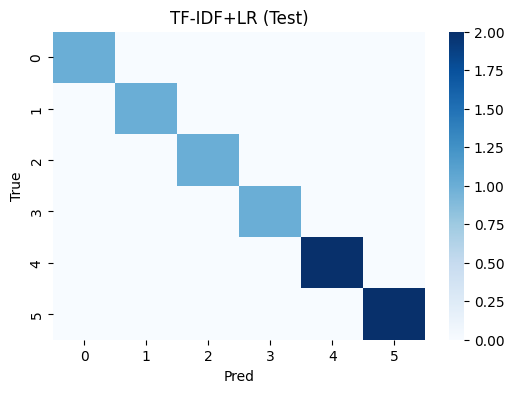

In [8]:
# %% [markdown]
# ## 3) Baseline 1 — TF-IDF + Logistic Regression

tfidf_lr = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    LogisticRegression(max_iter=2000, n_jobs=-1, C=2.0)
)
tfidf_lr.fit(df_train["text"], y_train)

pred_lr_val  = tfidf_lr.predict(df_val["text"])
pred_lr_test = tfidf_lr.predict(df_test["text"])

show_report(y_val,  pred_lr_val,  "TF-IDF+LR (Val)")
show_report(y_test, pred_lr_test, "TF-IDF+LR (Test)")
plot_confusion(y_test, pred_lr_test, "TF-IDF+LR (Test)")



== TF-IDF+LR (Val) ==
                 precision    recall  f1-score   support

   alarm_cancel     1.0000    1.0000    1.0000         1
    flight_book     1.0000    1.0000    1.0000         1
home_automation     1.0000    1.0000    1.0000         1
     music_play     1.0000    1.0000    1.0000         1
reminder_create     1.0000    1.0000    1.0000         2
  weather_query     1.0000    1.0000    1.0000         2

       accuracy                         1.0000         8
      macro avg     1.0000    1.0000    1.0000         8
   weighted avg     1.0000    1.0000    1.0000         8

Macro-F1: 1.0

== TF-IDF+LR (Test) ==
                 precision    recall  f1-score   support

   alarm_cancel     1.0000    1.0000    1.0000         1
    flight_book     1.0000    1.0000    1.0000         1
home_automation     1.0000    1.0000    1.0000         1
     music_play     1.0000    1.0000    1.0000         1
reminder_create     1.0000    1.0000    1.0000         2
  weather_query     1.0

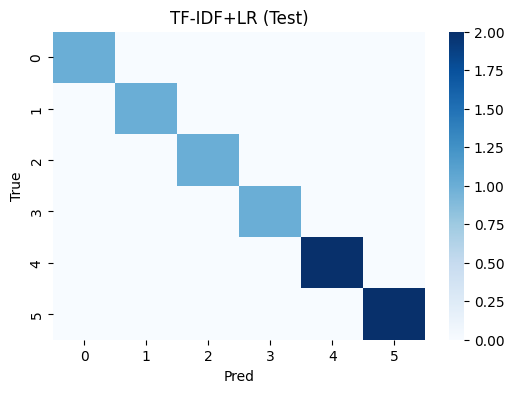

In [9]:
# %% [markdown]
# ## 3) Baseline 1 — TF-IDF + Logistic Regression

tfidf_lr = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    LogisticRegression(max_iter=2000, n_jobs=-1, C=2.0)
)
tfidf_lr.fit(df_train["text"], y_train)

pred_lr_val  = tfidf_lr.predict(df_val["text"])
pred_lr_test = tfidf_lr.predict(df_test["text"])

show_report(y_val,  pred_lr_val,  "TF-IDF+LR (Val)")
show_report(y_test, pred_lr_test, "TF-IDF+LR (Test)")
plot_confusion(y_test, pred_lr_test, "TF-IDF+LR (Test)")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



== W2V-Avg + Dense (Val) ==
                 precision    recall  f1-score   support

   alarm_cancel     0.0000    0.0000    0.0000         1
    flight_book     0.0000    0.0000    0.0000         1
home_automation     0.0000    0.0000    0.0000         1
     music_play     0.0000    0.0000    0.0000         1
reminder_create     0.4000    1.0000    0.5714         2
  weather_query     0.6667    1.0000    0.8000         2

       accuracy                         0.5000         8
      macro avg     0.1778    0.3333    0.2286         8
   weighted avg     0.2667    0.5000    0.3429         8

Macro-F1: 0.22857142857142856

== W2V-Avg + Dense (Test) ==
                 precision    recall  f1-score   support

   alarm_cancel     0.0000    0.0000    0.0000         1
    flight_book     0.0000    0.0000    0.0000         1
home_automation     0.0000    0.0000    0.0000         1
     music_play     0.0000    0.0000    0.0000         1
reminder_create     0.4000    1.0000    0.5714      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

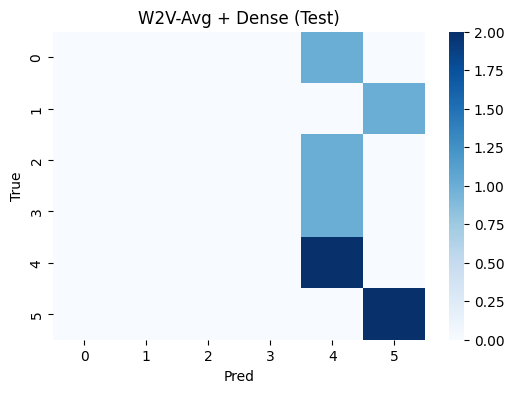

In [10]:
# %% [markdown]
# ## 4) Baseline 2 — Word2Vec (Average) + Dense

# Train Word2Vec trên text train (hoặc gộp train+val)
sent_train = [str(s).split() for s in df_train["text"]]
sent_all   = [str(s).split() for s in pd.concat([df_train["text"], df_val["text"]])]
w2v_dim    = 100

w2v = Word2Vec(
    sentences=sent_all,
    vector_size=w2v_dim, window=5, min_count=1, workers=4, seed=SEED, epochs=20
)

def sentence_to_avg(text, model, dim):
    toks = str(text).split()
    vecs = [model.wv[w] for w in toks if w in model.wv]
    if not vecs:
        return np.zeros(dim, dtype="float32")
    return np.mean(vecs, axis=0).astype("float32")

Xtr_avg = np.vstack([sentence_to_avg(t, w2v, w2v_dim) for t in df_train["text"]])
Xva_avg = np.vstack([sentence_to_avg(t, w2v, w2v_dim) for t in df_val["text"]])
Xte_avg = np.vstack([sentence_to_avg(t, w2v, w2v_dim) for t in df_test["text"]])

# MLP nhỏ cho phân loại
from tensorflow.keras.layers import Input
from tensorflow.keras import Input as KInput
from tensorflow.keras import Model

mlp = Sequential([
    Dense(128, activation="relu", input_shape=(w2v_dim,)),
    Dropout(0.4),
    Dense(num_classes, activation="softmax")
])
mlp.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cb = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(factor=0.5, patience=4)
]
hist = mlp.fit(Xtr_avg, y_train, validation_data=(Xva_avg, y_val),
               epochs=50, batch_size=64, callbacks=cb, verbose=0)

pred_dense_val  = mlp.predict(Xva_avg, verbose=0).argmax(-1)
pred_dense_test = mlp.predict(Xte_avg, verbose=0).argmax(-1)

show_report(y_val,  pred_dense_val,  "W2V-Avg + Dense (Val)")
show_report(y_test, pred_dense_test, "W2V-Avg + Dense (Test)")
plot_confusion(y_test, pred_dense_test, "W2V-Avg + Dense (Test)")


In [11]:
# %% [markdown]
# ## 5) Chuẩn bị chuỗi cho LSTM: Tokenizer & Padding

# Tokenizer chỉ fit trên train để tránh leak; OOV dùng token đặc biệt
vocab_size = 20000   # bạn có thể tăng nếu dữ liệu lớn
max_len    = 40      # độ dài cắt/pad chuỗi

tok = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tok.fit_on_texts(df_train["text"])

def to_pad(seqs, maxlen=max_len):
    return pad_sequences(tok.texts_to_sequences(seqs), maxlen=maxlen, padding="post", truncating="post")

Xtr_pad = to_pad(df_train["text"])
Xva_pad = to_pad(df_val["text"])
Xte_pad = to_pad(df_test["text"])

vocab_size_eff = min(vocab_size, len(tok.word_index) + 1)
print("Vocab (effective):", vocab_size_eff, " MaxLen:", max_len)


Vocab (effective): 42  MaxLen: 40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



== Embedding(Pretrained W2V) + LSTM (Val) ==
                 precision    recall  f1-score   support

   alarm_cancel     0.0000    0.0000    0.0000         1
    flight_book     0.0000    0.0000    0.0000         1
home_automation     0.0000    0.0000    0.0000         1
     music_play     0.0000    0.0000    0.0000         1
reminder_create     0.0000    0.0000    0.0000         2
  weather_query     0.2500    1.0000    0.4000         2

       accuracy                         0.2500         8
      macro avg     0.0417    0.1667    0.0667         8
   weighted avg     0.0625    0.2500    0.1000         8

Macro-F1: 0.06666666666666667

== Embedding(Pretrained W2V) + LSTM (Test) ==
                 precision    recall  f1-score   support

   alarm_cancel     0.0000    0.0000    0.0000         1
    flight_book     0.0000    0.0000    0.0000         1
home_automation     0.0000    0.0000    0.0000         1
     music_play     0.0000    0.0000    0.0000         1
reminder_create   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

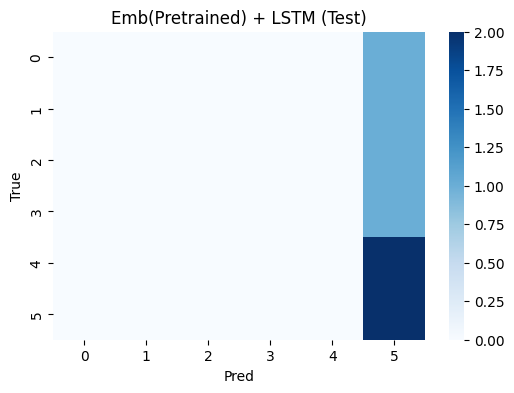

In [12]:
# %% [markdown]
# ## 6) LSTM – Embedding Pre-trained từ Word2Vec (đóng băng)
# Dùng w2v ở mục 4 để khởi tạo embedding_matrix

embedding_dim = w2v_dim
embedding_matrix = np.zeros((vocab_size_eff, embedding_dim), dtype="float32")
for w, i in tok.word_index.items():
    if i >= vocab_size_eff:
        continue
    if w in w2v.wv:
        embedding_matrix[i] = w2v.wv[w]
# Note: index 0 dùng cho PAD => zero vector

lstm_pre = Sequential([
    Embedding(input_dim=vocab_size_eff,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),  # đóng băng để đánh giá “pretrained pure”
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_classes, activation="softmax")
])
lstm_pre.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cb = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(factor=0.5, patience=2)
]
hist = lstm_pre.fit(Xtr_pad, y_train, validation_data=(Xva_pad, y_val),
                    epochs=30, batch_size=64, callbacks=cb, verbose=0)

pred_pre_val  = lstm_pre.predict(Xva_pad, verbose=0).argmax(-1)
pred_pre_test = lstm_pre.predict(Xte_pad, verbose=0).argmax(-1)

show_report(y_val,  pred_pre_val,  "Embedding(Pretrained W2V) + LSTM (Val)")
show_report(y_test, pred_pre_test, "Embedding(Pretrained W2V) + LSTM (Test)")
plot_confusion(y_test, pred_pre_test, "Emb(Pretrained) + LSTM (Test)")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



== Embedding(Scratch) + LSTM (Val) ==
                 precision    recall  f1-score   support

   alarm_cancel     0.0000    0.0000    0.0000         1
    flight_book     0.0000    0.0000    0.0000         1
home_automation     0.0000    0.0000    0.0000         1
     music_play     0.0000    0.0000    0.0000         1
reminder_create     0.2500    1.0000    0.4000         2
  weather_query     0.0000    0.0000    0.0000         2

       accuracy                         0.2500         8
      macro avg     0.0417    0.1667    0.0667         8
   weighted avg     0.0625    0.2500    0.1000         8

Macro-F1: 0.06666666666666667

== Embedding(Scratch) + LSTM (Test) ==
                 precision    recall  f1-score   support

   alarm_cancel     0.0000    0.0000    0.0000         1
    flight_book     0.0000    0.0000    0.0000         1
home_automation     0.0000    0.0000    0.0000         1
     music_play     0.0000    0.0000    0.0000         1
reminder_create     0.2500    1.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

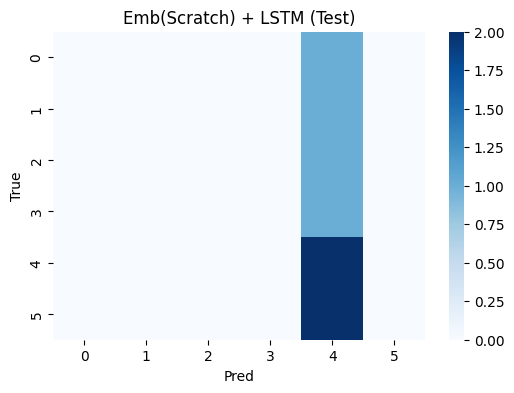

In [13]:
# %% [markdown]
# ## 7) LSTM – Embedding từ đầu (trainable)

lstm_scratch = Sequential([
    Embedding(input_dim=vocab_size_eff,
              output_dim=128,
              input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_classes, activation="softmax")
])
lstm_scratch.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cb = [
    EarlyStopping(patience=6, restore_best_weights=True, monitor="val_accuracy"),
    ReduceLROnPlateau(factor=0.5, patience=3)
]
hist = lstm_scratch.fit(Xtr_pad, y_train, validation_data=(Xva_pad, y_val),
                        epochs=40, batch_size=64, callbacks=cb, verbose=0)

pred_sc_val  = lstm_scratch.predict(Xva_pad, verbose=0).argmax(-1)
pred_sc_test = lstm_scratch.predict(Xte_pad, verbose=0).argmax(-1)

show_report(y_val,  pred_sc_val,  "Embedding(Scratch) + LSTM (Val)")
show_report(y_test, pred_sc_test, "Embedding(Scratch) + LSTM (Test)")
plot_confusion(y_test, pred_sc_test, "Emb(Scratch) + LSTM (Test)")


,Pipeline,MacroF1(Test)
0,TF-IDF + LR,1.0000
1,W2V-Avg + Dense,0.2286
2,Emb(Pretrained W2V) + LSTM,0.0667
3,Emb(Scratch) + LSTM,0.0667


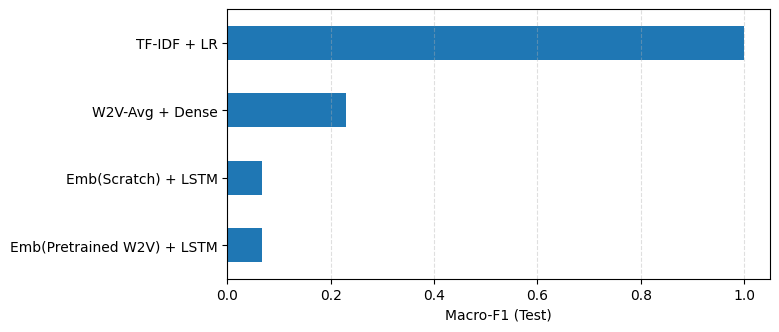

In [14]:
# %% [markdown]
# ## 8) So sánh macro-F1 (Test)

scores = {
    "TF-IDF + LR":                 f1_score(y_test, pred_lr_test,  average="macro") if 'pred_lr_test'  in globals() else np.nan,
    "W2V-Avg + Dense":             f1_score(y_test, pred_dense_test, average="macro") if 'pred_dense_test' in globals() else np.nan,
    "Emb(Pretrained W2V) + LSTM":  f1_score(y_test, pred_pre_test,  average="macro") if 'pred_pre_test' in globals() else np.nan,
    "Emb(Scratch) + LSTM":         f1_score(y_test, pred_sc_test,   average="macro") if 'pred_sc_test'  in globals() else np.nan,
}
df_scores = pd.DataFrame({"Pipeline": list(scores.keys()),
                          "MacroF1(Test)": [round(v, 4) for v in scores.values()]})
display(df_scores.sort_values("MacroF1(Test)", ascending=False).reset_index(drop=True))

ax = df_scores.sort_values("MacroF1(Test)").plot(kind="barh", x="Pipeline", y="MacroF1(Test)", legend=False, figsize=(7,3.5))
ax.set_xlabel("Macro-F1 (Test)"); ax.set_ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.show()


In [15]:
# %% [markdown]
# ## 9) Phân tích định tính
samples = [
    "can you remind me to not call my mom",
    "is it going to be sunny or rainy tomorrow",
    "find a flight from new york to london but not through paris"
]

def predict_all(texts):
    out = {}
    out["TF-IDF + LR"] = le.inverse_transform(tfidf_lr.predict(texts))
    out["W2V-Avg + Dense"] = le.inverse_transform(mlp.predict(np.vstack([sentence_to_avg(t, w2v, w2v_dim) for t in texts]), verbose=0).argmax(-1))
    out["Emb(Pretrained) + LSTM"] = le.inverse_transform(lstm_pre.predict(to_pad(texts), verbose=0).argmax(-1))
    out["Emb(Scratch) + LSTM"]    = le.inverse_transform(lstm_scratch.predict(to_pad(texts), verbose=0).argmax(-1))
    return out

preds = predict_all(samples)
for i, s in enumerate(samples):
    print(f"\nText[{i}]: {s}")
    for k in preds:
        print(f"  {k:26s} -> {preds[k][i]}")



Text[0]: can you remind me to not call my mom
  TF-IDF + LR                -> reminder_create
  W2V-Avg + Dense            -> reminder_create
  Emb(Pretrained) + LSTM     -> weather_query
  Emb(Scratch) + LSTM        -> reminder_create

Text[1]: is it going to be sunny or rainy tomorrow
  TF-IDF + LR                -> weather_query
  W2V-Avg + Dense            -> weather_query
  Emb(Pretrained) + LSTM     -> weather_query
  Emb(Scratch) + LSTM        -> reminder_create

Text[2]: find a flight from new york to london but not through paris
  TF-IDF + LR                -> flight_book
  W2V-Avg + Dense            -> reminder_create
  Emb(Pretrained) + LSTM     -> weather_query
  Emb(Scratch) + LSTM        -> reminder_create
